In [1]:
#Data Handling
import numpy as np 
import pandas as pd 

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#statistics
from scipy import stats

In [2]:
data = pd.read_csv('Employee.csv')
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [4]:
data['LeaveOrNot'] = data['LeaveOrNot'].astype(object)
data['PaymentTier'] = data['PaymentTier'].astype(object)

In [5]:
data.shape

(4653, 9)

In [6]:
import os
pic_path = './picture/'

In [7]:
tmp  = list(data.dtypes != np.int64)
cols = data.columns[tmp].tolist()
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched', 'LeaveOrNot']


In [8]:
tmp  = list(data.dtypes == np.int64)
num_cols = data.columns[tmp].tolist()
print(num_cols)

['JoiningYear', 'Age', 'ExperienceInCurrentDomain']


In [10]:
def plot_hist(name):
    sns.countplot(x = name, data = data)
    plt.ylabel('Total')
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

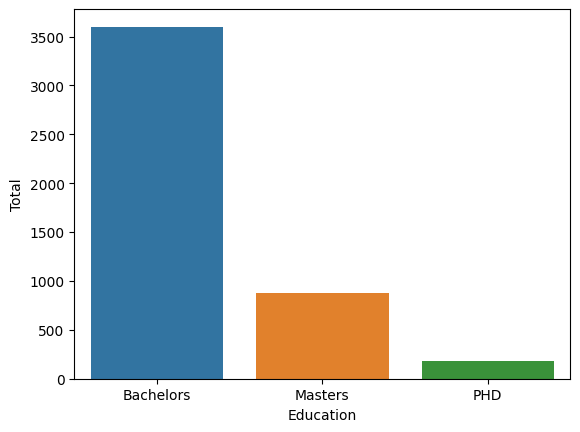

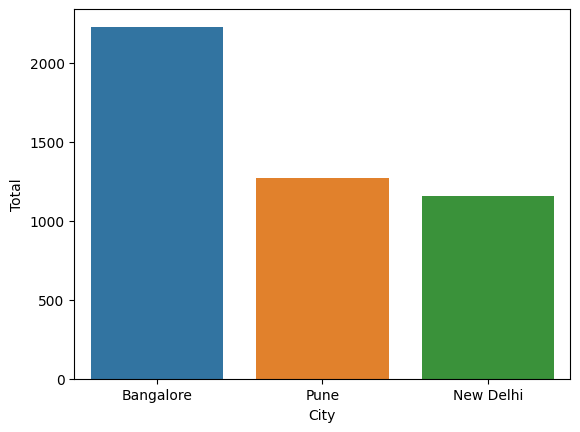

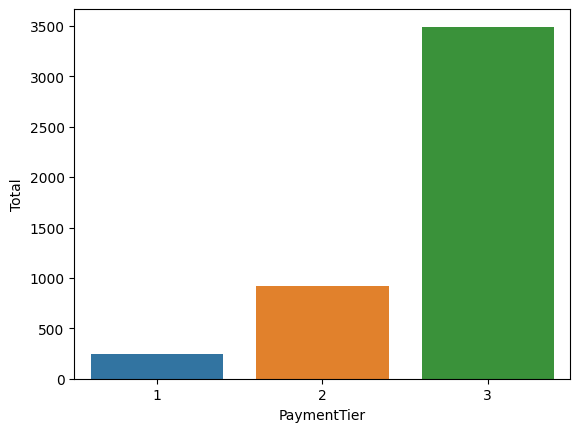

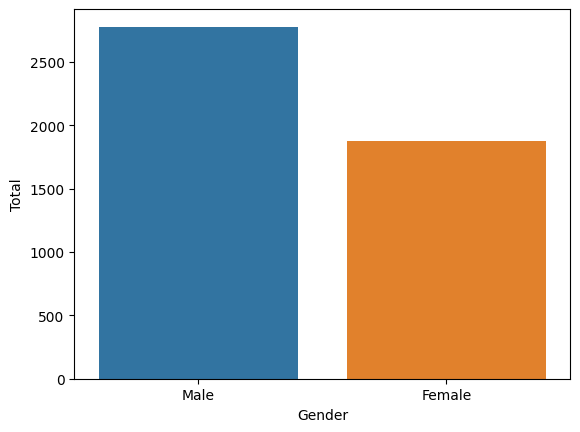

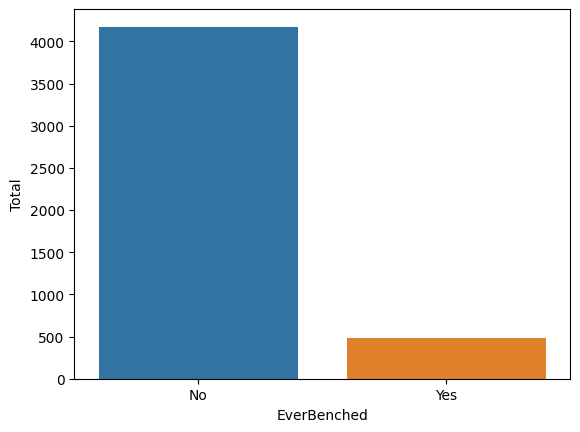

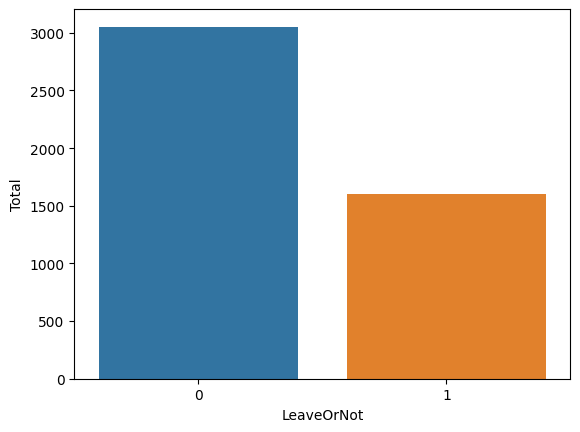

<Figure size 640x480 with 0 Axes>

In [11]:
tmp = list(map(plot_hist, cols))

In [12]:
def plot_box(name):
    sns.boxplot(data = data, x = name)
    plt.xlabel(name)
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

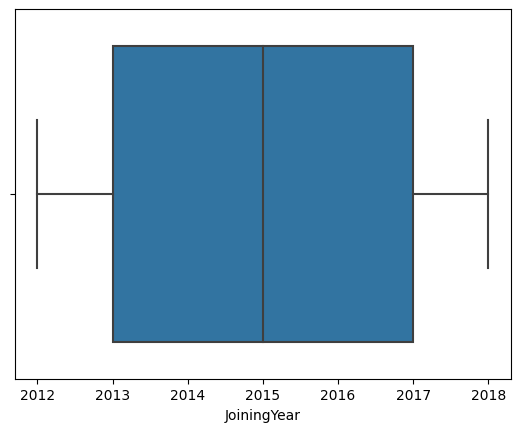

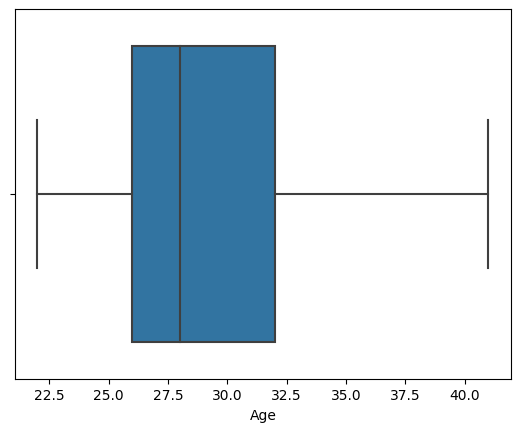

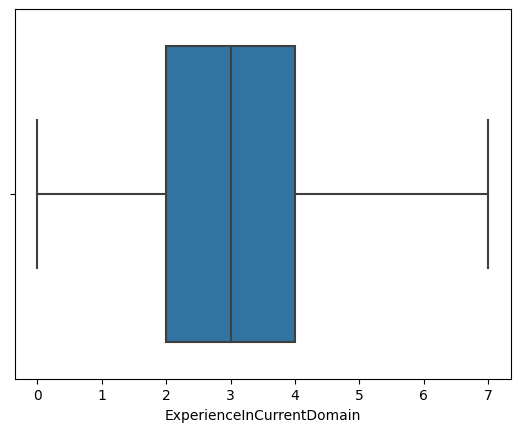

<Figure size 640x480 with 0 Axes>

In [13]:
tmp = list(map(plot_box, num_cols))

In [9]:
cols.remove('LeaveOrNot')
print(cols)

['Education', 'City', 'PaymentTier', 'Gender', 'EverBenched']


In [18]:
def plot_bi_hist(name):
    sns.countplot(x = name, data = data, hue = 'LeaveOrNot')
    plt.ylabel('Total')
    plt.xlabel(name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

In [19]:
def plot_bi_box(name):
    sns.boxplot(data = data, x = 'LeaveOrNot', y = name)
    name = "bivariate_" + name
    plt.savefig(os.path.join(pic_path, name))
    plt.figure().clear()

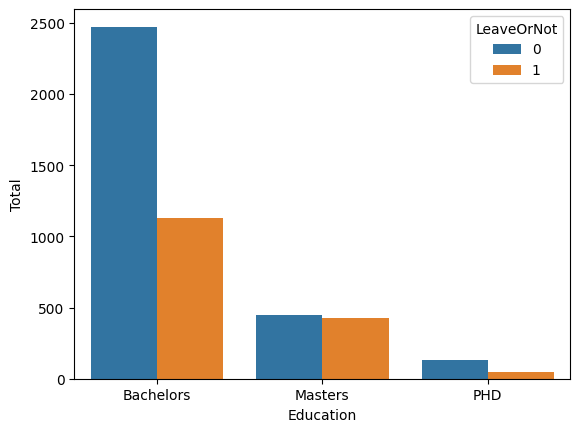

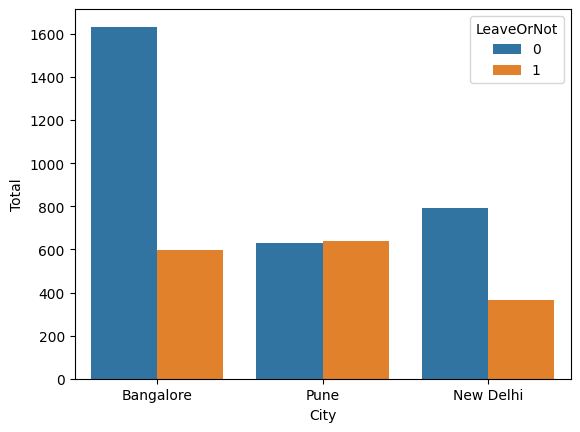

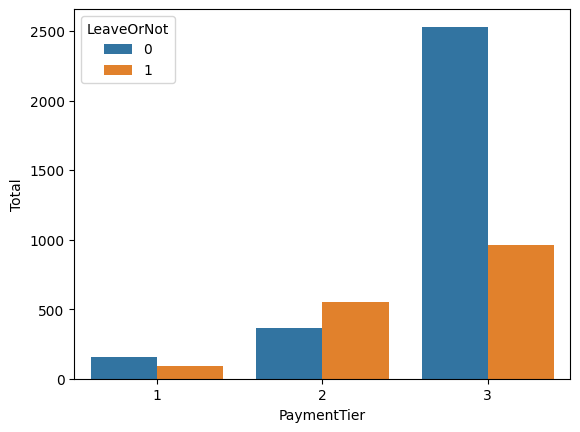

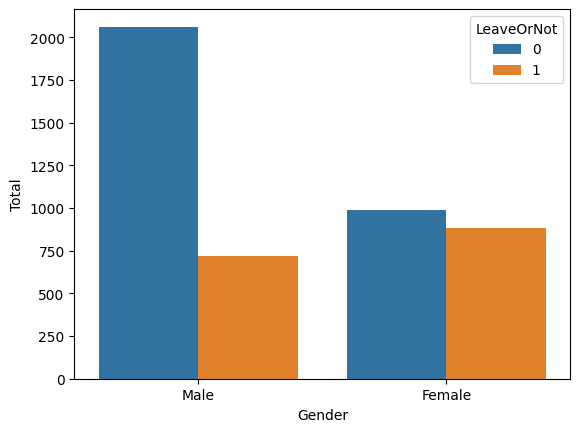

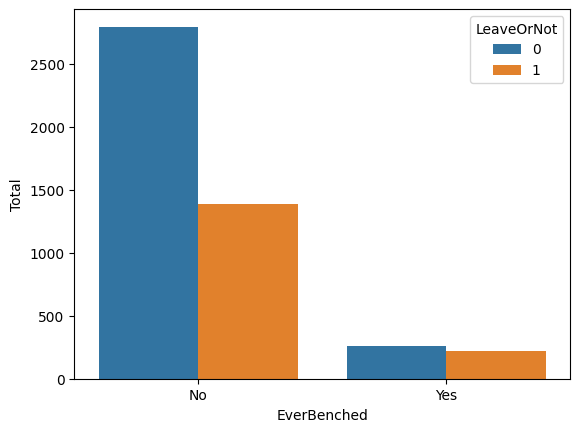

<Figure size 640x480 with 0 Axes>

In [20]:
tmp = list(map(plot_bi_hist, cols))

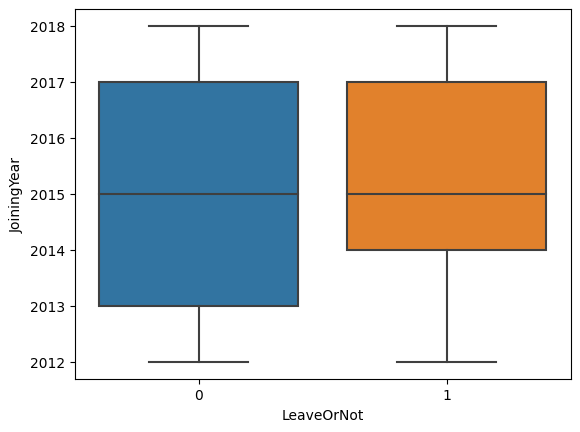

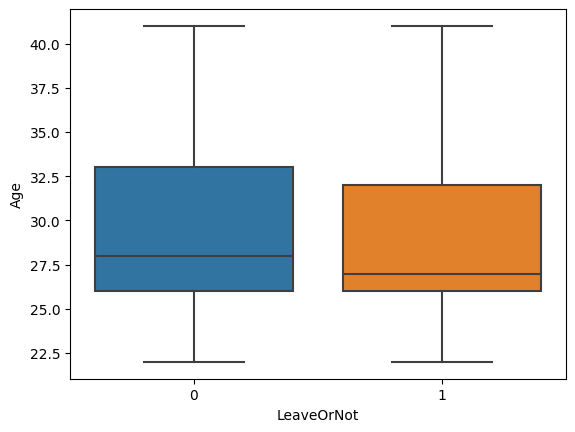

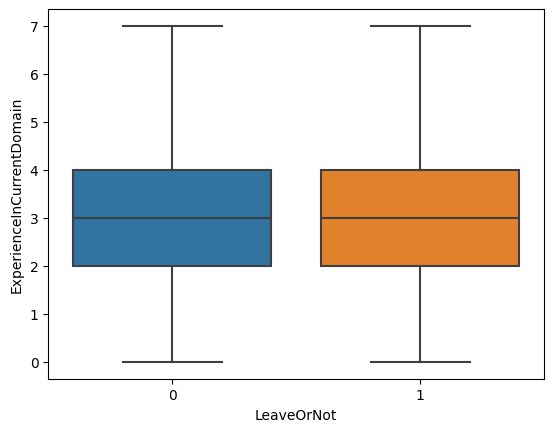

<Figure size 640x480 with 0 Axes>

In [21]:
tmp = list(map(plot_bi_box, num_cols))

In [25]:
def stats_test(col):
  if data[col].dtype == np.int64 or data[col].dtype == np.float64:
    tmp0 = data.loc[data['LeaveOrNot'] == 0, col].values
    tmp1 = data.loc[data['LeaveOrNot'] == 1, col].values

    result = stats.ttest_ind(tmp0, tmp1)[0:2]

  else:
    contingency_table = data.pivot_table(index = [col], columns = 'LeaveOrNot', values = 'Age', aggfunc = 'count')
    contingency_table = contingency_table.fillna(0)
    contingency_table = contingency_table.values

    result = stats.chi2_contingency(contingency_table, correction = False)[0:2]

  return result

In [26]:
all_cols = data.columns[:-1].tolist()
results = {c: stats_test(c) for c in all_cols}
print(results)

{'Education': (101.83014138498626, 7.724417739147332e-23), 'JoiningYear': (-12.601776125876363, 7.90161666436133e-36), 'City': (206.15885400194648, 1.7106992135618012e-45), 'PaymentTier': (338.6305486794045, 2.9329904732261673e-74), 'Age': (3.491261554959713, 0.0004852123420648862), 'Gender': (226.64164837884488, 3.219334068915125e-51), 'EverBenched': (28.627472496502868, 8.772866504669789e-08), 'ExperienceInCurrentDomain': (2.081296101564669, 0.03746138354045199)}


全部都顯著，加上feature selection應該要來回對照，所以就先全部餵進去吧

In [10]:
seed = 1126

In [42]:
x = data.drop(['LeaveOrNot'], axis=1)
y = data['LeaveOrNot'].astype(np.int64)

In [12]:
import category_encoders as ce
from sklearn.model_selection import train_test_split

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed, stratify = y)

如果你是用lightgbm或catboost的話，他可以直接吃categorical data

用簡單的leave-one-out target encoding encode categorical data

In [44]:
encoder = ce.LeaveOneOutEncoder(cols = cols, sigma = 0.05)
encoder.fit(x_train, y_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [45]:
x_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
939,0.30982,2017,0.496538,0.271813,27,0.256901,0.33094,5
3326,0.30982,2017,0.496538,0.599185,33,0.476287,0.33094,2
3113,0.30982,2014,0.269016,0.271813,40,0.476287,0.33094,0
69,0.50142,2017,0.269016,0.271813,40,0.476287,0.33094,2
3546,0.50142,2018,0.496538,0.271813,31,0.256901,0.33094,2


將數值資料standardize

In [46]:
from sklearn.preprocessing import StandardScaler

std_encoder = StandardScaler()
x_train = std_encoder.fit_transform(x_train)
x_test = std_encoder.transform(x_test)

In [47]:
x_train[0:3]

array([[-0.44294974,  1.03450786,  1.59624031, -0.55293904, -0.49837554,
        -0.81065918, -0.33720078,  1.34599141],
       [-0.44294974,  1.03450786,  1.59624031,  1.95811516,  0.74294975,
         1.23356403, -0.33720078, -0.59028018],
       [-0.44294974, -0.57767843, -0.7831341 , -0.55293904,  2.19116258,
         1.23356403, -0.33720078, -1.88112791]])

In [48]:
print(x_train.shape)
print(x_test.shape)

(3722, 8)
(931, 8)


In [68]:
x_train_copy = pd.DataFrame(x_train, columns = data.columns[:-1])
x_train_copy.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,-0.442950,1.034508,1.596240,-0.552939,-0.498376,-0.810659,-0.337201,1.345991
1,-0.442950,1.034508,1.596240,1.958115,0.742950,1.233564,-0.337201,-0.590280
2,-0.442950,-0.577678,-0.783134,-0.552939,2.191163,1.233564,-0.337201,-1.881128
3,2.047278,1.034508,-0.783134,-0.552939,2.191163,1.233564,-0.337201,-0.590280
4,2.047278,1.571903,1.596240,-0.552939,0.329175,-0.810659,-0.337201,-0.590280


<Axes: >

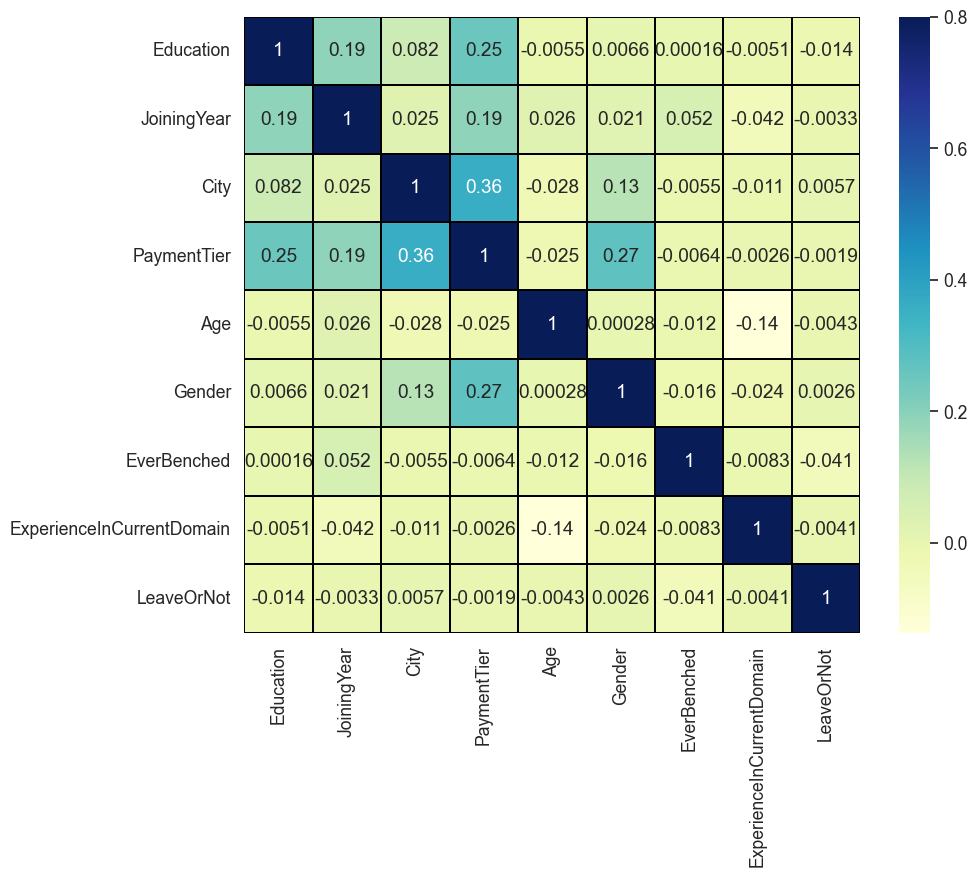

In [70]:
sns.set(font_scale = 1.15)
plt.figure(figsize = (10, 8))
sns.heatmap(pd.concat([x_train_copy, y_train], axis = 1).corr(), vmax = 0.8, linewidths = 0.01, square = True, 
            annot = True, cmap='YlGnBu',
linecolor = 'black')

用border line smote去做upsampling

In [65]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import BorderlineSMOTE

smote_enn = BorderlineSMOTE(random_state = seed)
x_train_resampled, y_train_resampled = smote_enn.fit_resample(x_train, y_train)

直接補到0 1同樣數量

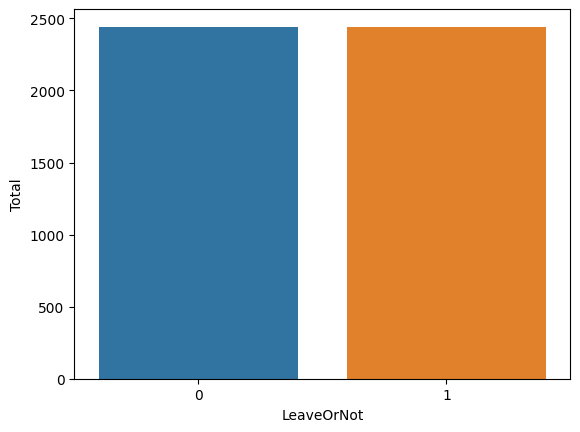

In [66]:
sns.countplot(x = y_train_resampled)
plt.ylabel('Total')
plt.xlabel('LeaveOrNot')
plt.show()

In [67]:
y_train_resampled.shape

(4884,)